In [266]:
# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import scipy.stats as ss

# data preprocessing
import pandas as pd
# linear algebra
import numpy as np

import itertools

In [3]:
plays_dataframe = pd.read_csv('PlayList.csv')
players_dataframe = pd.read_csv('PlayerTrackData.csv')
injuries_dataframe = pd.read_csv('InjuryRecord.csv')

### Exploring plays data

In [4]:
plays_dataframe.head()

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,1,QB,QB
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,2,QB,QB
2,26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,3,QB,QB
3,26624,26624-1,26624-1-4,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,4,QB,QB
4,26624,26624-1,26624-1-5,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,5,QB,QB


Let's explore this data.First, let's find how many games, players and plays we have in total.

In [5]:
plays_overrall = plays_dataframe.PlayKey.nunique()  # unique selects the unique values, n in front goes for number
players_overall = plays_dataframe.PlayerKey.nunique()
games_overall = plays_dataframe.GameID.nunique()
print('Overall we have {} players,'.format(players_overall) + '{} plays'.format(plays_overrall) + 
     ' and {} games'.format(games_overall))

Overall we have 250 players,267005 plays and 5712 games


In [6]:
plays_dataframe.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267005 entries, 0 to 267004
Data columns (total 14 columns):
PlayerKey         267005 non-null int64
GameID            267005 non-null object
PlayKey           267005 non-null object
RosterPosition    267005 non-null object
PlayerDay         267005 non-null int64
PlayerGame        267005 non-null int64
StadiumType       250095 non-null object
FieldType         267005 non-null object
Temperature       267005 non-null int64
Weather           248314 non-null object
PlayType          266638 non-null object
PlayerGamePlay    267005 non-null int64
Position          267005 non-null object
PositionGroup     267005 non-null object
dtypes: int64(5), object(9)
memory usage: 28.5+ MB


Let's explore this data types:games, plays and players.Idea is to clean the data a little bit if values have appoximately the same meaning,deleting the irrelevant ones to not trahs the graphs(that have very few entries) and than create a diagrams to look for correlations.

In [7]:
plays_dataframe.Weather.unique()

array(['Clear and warm', 'Mostly Cloudy', 'Sunny', 'Clear', 'Cloudy',
       'Cloudy, fog started developing in 2nd quarter', 'Rain',
       'Partly Cloudy', 'Mostly cloudy', 'Cloudy and cold',
       'Cloudy and Cool', 'Rain Chance 40%', 'Controlled Climate',
       'Sunny and warm', 'Partly cloudy', 'Clear and Cool',
       'Clear and cold', 'Sunny and cold', 'Indoor', nan, 'Partly Sunny',
       'N/A (Indoors)', 'Mostly Sunny', 'Indoors', 'Clear Skies',
       'Partly sunny', 'Showers', 'N/A Indoor', 'Sunny and clear', 'Snow',
       'Scattered Showers', 'Party Cloudy', 'Clear skies',
       'Rain likely, temps in low 40s.', 'Hazy', 'Partly Clouidy',
       'Sunny Skies', 'Overcast', 'Cloudy, 50% change of rain', 'Fair',
       'Light Rain', 'Partly clear', 'Mostly Coudy', '10% Chance of Rain',
       'Cloudy, chance of rain', 'Heat Index 95',
       'Sunny, highs to upper 80s', 'Sun & clouds',
       'Heavy lake effect snow', 'Mostly sunny', 'Cloudy, Rain',
       'Sunny, Windy', '

We have many types of weather, but we can separate them in a few categories: **rain, snow, clear, clody and indoors** when the weather doesn't matter.But there are also some that we cannot strictly categorize.Let's see the precantage of each weather type.

I don't see much meaning in categories such as Cold and Heat Index 95.

In [8]:
plays_dataframe.Weather.value_counts(normalize=True)['Cold']
plays_dataframe.Weather.value_counts(normalize=True)['Heat Index 95']

0.0018323574184298912

In [9]:
plays_dataframe.Weather.value_counts(normalize=True)

Cloudy                                                                              0.244469
Sunny                                                                               0.208317
Partly Cloudy                                                                       0.114625
Clear                                                                               0.104396
Mostly Cloudy                                                                       0.045008
                                                                                      ...   
30% Chance of Rain                                                                  0.001426
Partly Clouidy                                                                      0.001216
Coudy                                                                               0.001120
Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.    0.000991
Party Cloudy                                                          

Now let's explore studium types and field types.

In [10]:
plays_dataframe.StadiumType.unique()

array(['Outdoor', 'Indoors', 'Oudoor', 'Outdoors', 'Open', 'Closed Dome',
       'Domed, closed', nan, 'Dome', 'Indoor', 'Domed',
       'Retr. Roof-Closed', 'Outdoor Retr Roof-Open', 'Retractable Roof',
       'Ourdoor', 'Indoor, Roof Closed', 'Retr. Roof - Closed', 'Bowl',
       'Outddors', 'Retr. Roof-Open', 'Dome, closed', 'Indoor, Open Roof',
       'Domed, Open', 'Domed, open', 'Heinz Field', 'Cloudy',
       'Retr. Roof - Open', 'Retr. Roof Closed', 'Outdor', 'Outside'],
      dtype=object)

In [11]:
plays_dataframe.FieldType.unique()

array(['Synthetic', 'Natural'], dtype=object)

So, FieldType can go directly without cleaning, but there are too many similar types of StadiumType => let's clean it.Heinz Field, Cloudy and Bowl have no meaning behind them => we need to delete them.

In [12]:
def clean_weather(row):
    cloudy = ['Cloudy 50% change of rain', 'Hazy', 'Cloudy.', 'Overcast', 'Mostly Cloudy',
          'Cloudy, fog started developing in 2nd quarter', 'Partly Cloudy',
          'Mostly cloudy', 'Rain Chance 40%',' Partly cloudy', 'Party Cloudy',
          'Rain likely, temps in low 40s', 'Partly Clouidy', 'Cloudy, 50% change of rain','Mostly Coudy', '10% Chance of Rain',
          'Cloudy, chance of rain', '30% Chance of Rain', 'Cloudy, light snow accumulating 1-3"',
          'cloudy', 'Coudy', 'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy fog started developing in 2nd quarter', 'Cloudy light snow accumulating 1-3"',
         'Cloudywith periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy 50% change of rain', 'Cloudy and cold',
       'Cloudy and Cool', 'Partly cloudy']
    
    clear = ['Clear, Windy',' Clear to Cloudy', 'Clear, highs to upper 80s',
             'Clear and clear','Partly sunny',
             'Clear, Windy', 'Clear skies', 'Sunny', 'Partly Sunny', 'Mostly Sunny', 'Clear Skies',
             'Sunny Skies', 'Partly clear', 'Fair', 'Sunny, highs to upper 80s', 'Sun & clouds', 'Mostly sunny','Sunny, Windy',
             'Mostly Sunny Skies', 'Clear and Sunny', 'Clear and sunny','Clear to Partly Cloudy', 'Clear Skies',
            'Clear and cold', 'Clear and warm', 'Clear and Cool', 'Sunny and cold', 'Sunny and warm', 'Sunny and clear']
    
    rainy = ['Rainy', 'Scattered Showers', 'Showers', 'Cloudy Rain', 'Light Rain', 'Rain shower', 'Rain likely, temps in low 40s.', 'Cloudy, Rain']
    
    snow = ['Heavy lake effect snow']
    
    indoor = ['Controlled Climate', 'Indoors', 'N/A Indoor', 'N/A (Indoors)']
        
    if row.Weather in cloudy:
        return 'Cloudy'
    
    if row.Weather in indoor:
        return 'Indoor'
    
    if row.Weather in clear:
        return 'Clear'
    
    if row.Weather in rainy:
        return 'Rain'
    
    if row.Weather in snow:
        return 'Snow'
      
    if row.Weather in ['Cloudy.', 'Heat Index 95', 'Cold']:
        return np.nan
    
    return row.Weather

def clean_stadiumtype(row):
    if row.StadiumType in ['Bowl', 'Heinz Field', 'Cloudy']:
        return np.nan
    else:
        return row.StadiumType
        


def clean_data(arr):
    play_df_cleaned = arr.copy()
    
    # clean StadiumType
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Oudoor|Outdoors|Ourdoor|Outddors|Outdor|Outside', 'Outdoor')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Indoors|Indoor, Roof Closed|Indoor, Open Roof', 'Indoor')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Closed Dome|Domed, closed|Domed, Open|Domed, open|Dome, closed|Domed', 'Dome')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Retr. Roof-Closed|Outdoor Retr Roof-Open|Retr. Roof - Closed|Retr. Roof-Open|Retr. Roof - Open|Retr. Roof Closed', 'Retractable Roof')
    play_df_cleaned['StadiumType'] = play_df_cleaned.apply(lambda row: clean_stadiumtype(row), axis=1)
    
    play_df_cleaned['Weather'] = play_df_cleaned.apply(lambda row: clean_weather(row), axis=1)
    
    return play_df_cleaned

plays_dataframe = clean_data(plays_dataframe)  # NEXT TIME CREATE A DIFFERENT VALUE, OR MANIPULATE WITH COPY!

In [13]:
plays_dataframe.Weather.unique()  # => everything works just OK.

array(['Clear', 'Cloudy', 'Rain', 'Indoor', nan, 'Snow'], dtype=object)

In [14]:
plays_dataframe.StadiumType.unique()

array(['Outdoor', 'Indoor', 'Open', 'Dome', nan, 'Retractable Roof'],
      dtype=object)

Let's plot everything we got.

In [15]:
game_info = plays_dataframe.loc[:, ['Weather', 'StadiumType', 'FieldType', 'Temperature']]
game_info.Temperature.unique()
game_info.Temperature.value_counts()

-999    24170
 68     14127
 72      6970
 61      6744
 71      6261
        ...  
 34       418
 32       383
 10       292
 26       243
 9        210
Name: Temperature, Length: 79, dtype: int64

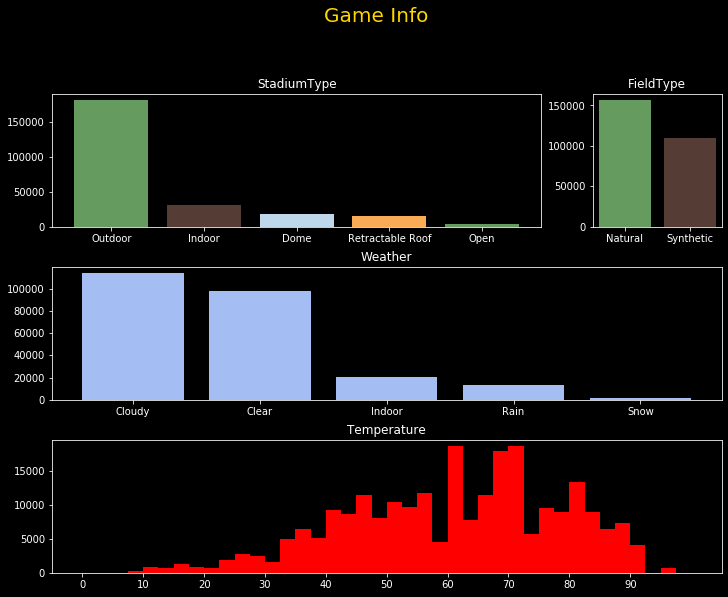

In [16]:
# Types of plots can be found in https://matplotlib.org/3.1.1/tutorials/introductory/sample_plots.html
plt.style.use('dark_background')
fig = plt.figure(figsize=(12, 12), edgecolor='silver')

# grid helps us to place our subplots. 'nrows' indicates that our 12 inches will be
# broken into 4 row 3 inches each, in which we can specify where to place sublplots.The same goes for cols
# Also we make distances between sublots with hspace(height) and wspace(width)
grid = plt.GridSpec(nrows=4, ncols=4, hspace=0.3, wspace=0.4)

# So, we place two plots with info about stadium in one row, each subplot containing half of the columns
stadiumT_fig = fig.add_subplot(grid[0, 0:3])
fieldT_fig = fig.add_subplot(grid[0, 3])
weather_fig = fig.add_subplot(grid[1, 0:])  # aka we place weather in the second row, containing all the columns
temperature_fig = fig.add_subplot(grid[2, :])


# .values gives the values of .keys()
weather_fig.bar(game_info.Weather.value_counts().keys(), 
                game_info.Weather.value_counts().values, color='#A4BEF3')
weather_fig.set_title('Weather')

# color indicates the colors of the bars.Can contain lists.
stadiumT_fig.bar(game_info.StadiumType.value_counts().keys(), 
                game_info.StadiumType.value_counts().values, color=['#659B5E', '#553D36', '#BFD7EA', '#F9AB55'])
stadiumT_fig.set_title('StadiumType')
fieldT_fig.bar(game_info.FieldType.value_counts().keys(), 
                game_info.FieldType.value_counts().values, color=['#659B5E', '#553D36'])
fieldT_fig.set_title('FieldType')

# For temperature it's better to use histogram.
temperature_fig.hist(game_info.Temperature.astype(int).values, bins=40, range = (0, 100), color='red')
temperature_fig.set_title('Temperature')
temperature_fig.set_xticks(range(0, 100, 10))


plt.suptitle('Game Info', fontsize=20, color='gold')
plt.show()  # only graph without any addtional info

*From here* we can conclude, that:
**Tempreture matters** because most of the games are held outsied.
**Tempreture and weather variate differently** -> we can look into and see the relations.

Let's look into the player's information.

In [17]:
plays_dataframe.head()

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear,Pass,1,QB,QB
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,Clear,Pass,2,QB,QB
2,26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63,Clear,Rush,3,QB,QB
3,26624,26624-1,26624-1-4,Quarterback,1,1,Outdoor,Synthetic,63,Clear,Rush,4,QB,QB
4,26624,26624-1,26624-1-5,Quarterback,1,1,Outdoor,Synthetic,63,Clear,Pass,5,QB,QB


We need only information about positions and GamePlay, including PlayerKey to measure amount of players.

In [328]:
player_info = plays_dataframe.loc[:, ['PlayerKey', 'PlayKey', 'RosterPosition', 'Position', 'PositionGroup', 'PlayerGamePlay']]

In [329]:
player_info.head()

,PlayerKey,PlayKey,RosterPosition,Position,PositionGroup,PlayerGamePlay
0,26624,26624-1-1,Quarterback,QB,QB,1
1,26624,26624-1-2,Quarterback,QB,QB,2
2,26624,26624-1-3,Quarterback,QB,QB,3
3,26624,26624-1-4,Quarterback,QB,QB,4
4,26624,26624-1-5,Quarterback,QB,QB,5


In [20]:
player_info.RosterPosition.unique()
player_info.PositionGroup.unique()
player_info.PlayerGamePlay.unique()
player_info.Position.unique()

array(['QB', 'Missing Data', 'WR', 'ILB', 'RB', 'DE', 'TE', 'FS', 'CB',
       'G', 'T', 'OLB', 'DT', 'SS', 'MLB', 'C', 'NT', 'DB', 'K', 'LB',
       'S', 'HB', 'P'], dtype=object)

Unique values show us, that we may not bother ourselfs with cleaning the data - all the data can be displayed just OK.Although it will be convenient to through the 'Missing data' rows,because they are low in quantity

In [330]:
player_info = player_info[player_info.Position != 'Missing Data']

Text(0.5, 0.98, 'Information about players')

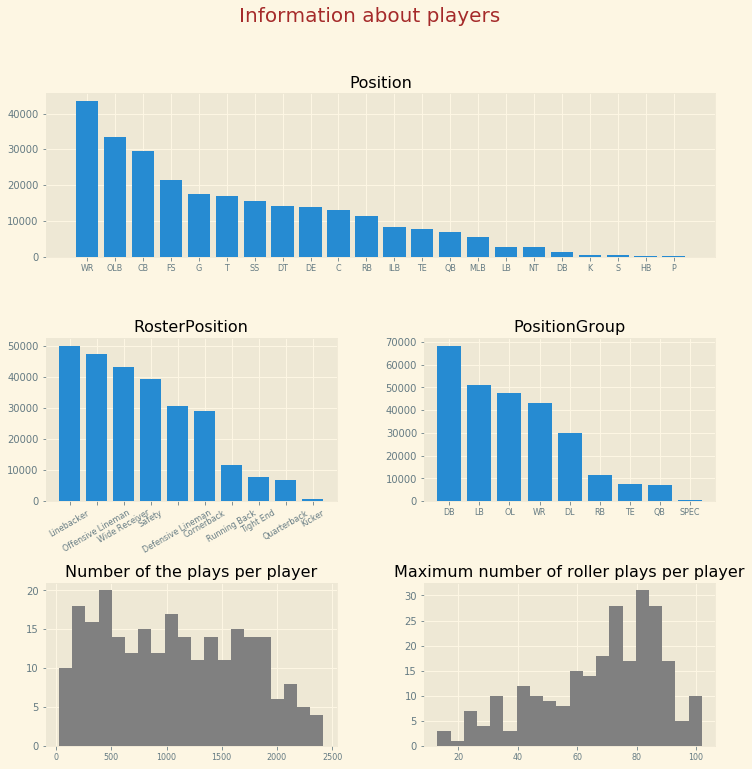

In [55]:
plt.style.use('Solarize_Light2')
figure = plt.figure(figsize=(12,12))
grid = plt.GridSpec(nrows=3, ncols=2, hspace=0.5, wspace=0.3)

position_fig = figure.add_subplot(grid[0, :])
rosterP_fig = figure.add_subplot(grid[1, 0])

position_fig.bar(player_info.Position.value_counts().keys(), player_info.Position.value_counts().values)
position_fig.set_title('Position', color='black')

rosterP_fig.bar(player_info.RosterPosition.value_counts().keys(), player_info.RosterPosition.value_counts().values)
plt.rc('xtick', labelsize=8) 
# set_xticklabels allows us to work with labels of x-axis, we implicitly write down the rotation degree.
rosterP_fig.set_xticklabels(player_info.RosterPosition.value_counts().keys(), rotation=30)
rosterP_fig.set_title('RosterPosition', color='black')

groupP_fig = figure.add_subplot(grid[1, 1])
groupP_fig.bar(player_info.PositionGroup.value_counts().keys(), player_info.PositionGroup.value_counts().values)
groupP_fig.set_title('PositionGroup', color='black')


playerK_fig = figure.add_subplot(grid[2, 0])
# groupby groups our dataframe by the values of PlayerKeys, count() counts non-NA values of RosterPostition,
# taking only values without PlayerKey
playerK_fig.hist(player_info.groupby(by=['PlayerKey']).count()['RosterPosition'].values, 
                bins=20, color='gray')
playerK_fig.set_title('Number of the plays per player', color='black')  # x shows amount of players that played y games

# Now let's count maximum plays for x players
maxRollPlays_fig = figure.add_subplot(grid[2, 1])
maxRollPlays_fig.hist(player_info.groupby(by=['PlayerKey']).PlayerGamePlay.max().values,
                bins=20, color='gray')
maxRollPlays_fig.set_title('Maximum number of roller plays per player', color='black')

figure.suptitle('Information about players', fontsize=20, color='brown')

*Infromation varies greatly* => all of that can lead to the injury.That's why we must analize everything.

**Visualizting play type**

In [57]:
play_type = plays_dataframe.loc[:, ['PlayType']]
play_type.head()

,PlayType
0,Pass
1,Pass
2,Rush
3,Rush
4,Pass


Text(0.5, 1.0, 'PlayType')

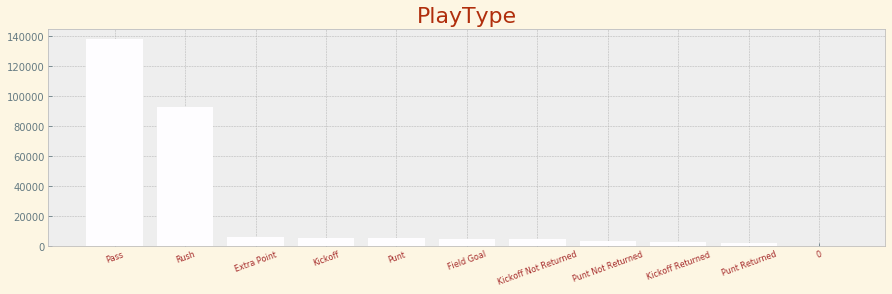

In [71]:
plt.style.use('bmh')
figure = plt.figure(figsize=(15, 4))
plt.bar(play_type.PlayType.value_counts().keys(), play_type.PlayType.value_counts().values, color='#FEFDFF')
plt.xticks(play_type.PlayType.value_counts().keys(), rotation=20, color='brown')
plt.title('PlayType', fontsize=22, color='#B02E0C')

Info shows us that,perhaps, most injuries occur during Push and Pass

## Analyze the track of the players

In [90]:
players_dataframe.head()

,PlayKey,time,event,x,y,dir,dis,o,s
0,26624-1-1,0.0,huddle_start_offense,87.46,28.93,288.24,0.01,262.33,0.13
1,26624-1-1,0.1,NaN,87.45,28.92,283.91,0.01,261.69,0.12
2,26624-1-1,0.2,NaN,87.44,28.92,280.40,0.01,261.17,0.12
3,26624-1-1,0.3,NaN,87.44,28.92,278.79,0.01,260.66,0.10
4,26624-1-1,0.4,NaN,87.44,28.92,275.44,0.01,260.27,0.09


In [99]:
coordinates = players_dataframe.loc[:, ['x', 'y']]
coordinates = coordinates.round()
coordinates_grouped = 

# print('Maximum of x:{}'.format(coordinates.x.max()) + ' .Minimum:'.format(coordinates.x.min()))
# print('Maximum of y:{}'.format(coordinates.y.max()) + ' .Minimum:'.format(coordinates.y.min()))

NameError: name 'x' is not defined

In [103]:
x_coord = coordinates.x.unique()
y_coord = coordinates.y.unique()
x_coord.sort()
y_coord.sort()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

## Injuries report

In [136]:
injuries_dataframe = pd.read_csv('InjuryRecord.csv')

In [137]:
injuries_dataframe.head()

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1


In [138]:
print('At all there are {} injuries'.format(len(injuries_dataframe)))
print('Among them there are {} injured PlayerKey'.format(len(injuries_dataframe.PlayerKey.unique())))
# => 5 people are injured twice, or some people are injured more than 2 times.
print('There are {} PlayerKey missing'.format(len(injuries_dataframe) - injuries_dataframe.PlayerKey.count()))

At all there are 105 injuries
Among them there are 100 injured PlayerKey
There are 0 PlayerKey missing


Text(0.5, 0.98, 'Injuries analysis')

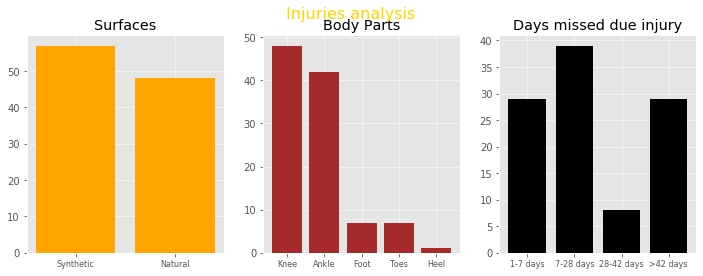

In [145]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
# grid = plt.GridSpec(nrows=1, ncols=3, wspace=0.3)
# surfaceInj = fig.add_subplot(grid=[0, 1])
axes[0].bar(injuries_dataframe.Surface.value_counts().keys(), 
            injuries_dataframe.Surface.value_counts().values, color='orange')
axes[0].set_title('Surfaces', color='black')

axes[1].bar(injuries_dataframe.BodyPart.value_counts().keys(), 
            injuries_dataframe.BodyPart.value_counts().values, color='brown')
axes[1].set_title('Body Parts', color='black')

# Let's count the number for specifical DM's.For that we must clean data a little bit.
# DM stands for days missed because of the injury.
injuries_dataframe_cleaned = injuries_dataframe.copy()
# Make a copy!!!!!! Otherwise when run a few times values will be negative and everything will be messed up
injuries_dataframe_cleaned.DM_M1 = injuries_dataframe_cleaned.DM_M1 - injuries_dataframe_cleaned.DM_M7
injuries_dataframe_cleaned.DM_M7 = injuries_dataframe_cleaned.DM_M7 - injuries_dataframe_cleaned.DM_M28
injuries_dataframe_cleaned.DM_M28 = injuries_dataframe_cleaned.DM_M28 - injuries_dataframe_cleaned.DM_M42
M1 = injuries_dataframe_cleaned.DM_M1.sum()
M7 = injuries_dataframe_cleaned.DM_M7.sum()
M28 = injuries_dataframe_cleaned.DM_M28.sum()
M42 = injuries_dataframe_cleaned.DM_M42.sum()
Ms = [M1, M7, M28, M42]
M_titles = ['1-7 days', '7-28 days', '28-42 days', '>42 days']

axes[2].bar(M_titles, Ms, color='black')
injuries_dataframe.head()
axes[2].set_title('Days missed due injury', color='black')

plt.suptitle('Injuries analysis', color='gold', fontsize=16)

We have almost equal amount of injuries on the different surfaces.The most frequent broken body parts are knees and ankles, but days missed vary greatly.

## Correlations between injuries.

Short turotial on most popular correlations: [Here](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9)

In [ ]:
# drop_duplicate drops identical rows => the rows with at least 1 value unmatching.We have many duplicates of info
# for unique games.
game_data_cleaned = plays_dataframe.loc[:, ['GameID', 'StadiumType', 'FieldType', 
                                            'Weather', 'Temperature']].drop_duplicates().reset_index().drop(columns='index')

Combine both cleaned game data and cleaned injuries.<br>
`Join` combines tow dataframes according to the indexes, that's why we needed to drop duplicates: indexes must be unique otherwise how can we join the same in one DF to another?<br>
We use `'outer'` - the thing that attaches what it could and then just fills everything else with NA, because otherwise we won't have Weather_Snow columns to seek correlations.Also we won't be able to build the most important thing - Injuries, that is our objective.It sound logical: if we take only 105 values(the size of injuries DF), than we have 100% chance of finding correlations when using `.corr()`.So we must take exmaples when we have no injuries or there is no point of exploring via heatmap!

Text(0.5, 1, 'Correlations between game moments and injuries')

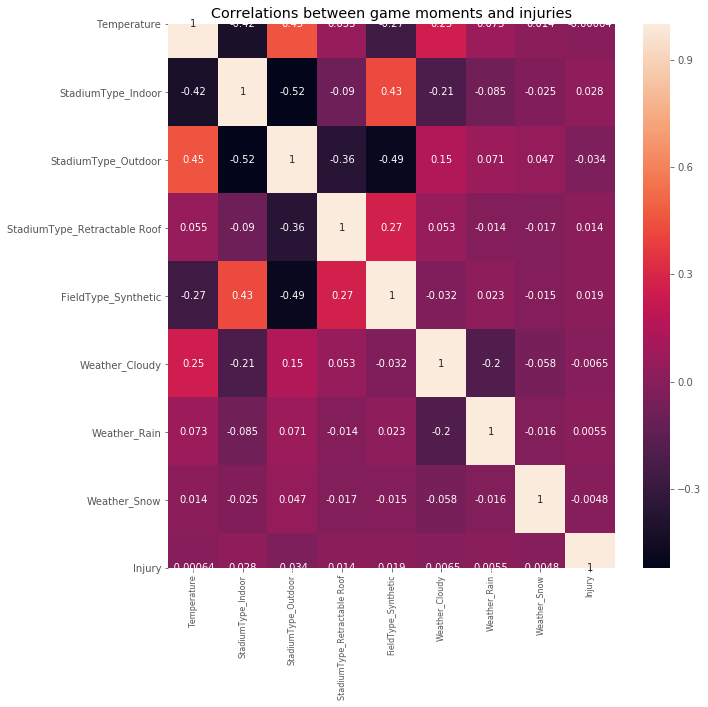

In [205]:
game_inj_df = injuries_dataframe_cleaned.set_index('GameID').join(game_data_cleaned.set_index('GameID'), how='outer')
# game_inj_df = injuries_dataframe_cleaned.set_index('GameID').join(game_data_cleaned.set_index('GameID'))


# filling the NAN of injuries with zeros.Other doesn't matter to us: we will seek correlations between injuries and
# game moments.
game_inj_df['DM_M1'] = game_inj_df['DM_M1'].fillna(0).astype(int)
game_inj_df['DM_M7'] = game_inj_df['DM_M7'].fillna(0).astype(int)
game_inj_df['DM_M28'] = game_inj_df['DM_M28'].fillna(0).astype(int)
game_inj_df['DM_M42'] = game_inj_df['DM_M42'].fillna(0).astype(int)

game_inj_df.DM_M1 = game_inj_df.DM_M1 - game_inj_df.DM_M7
game_inj_df.DM_M7 = game_inj_df.DM_M7 - game_inj_df.DM_M28
game_inj_df.DM_M28 = game_inj_df.DM_M28 - game_inj_df.DM_M42


# Injury to seek correlation beetween them.If there is an injury, than place 1, otherwise 0(although 
# when joining DF the default way we will have no non-1 values).
game_inj_df['Injury'] = game_inj_df.loc[:, 'DM_M1'] + game_inj_df.loc[:, 'DM_M7'] + (game_inj_df.loc[:, 'DM_M28'] 
+ game_inj_df.loc[:, 'DM_M42'])


# drop unneeded PlayerKey, PlayKey
game_inj_df = game_inj_df.drop(columns=['PlayerKey', 'PlayKey'])

# We should create dummies for all categorical values.We can use the fucntion on the whole DF.
# Thanks to dropping first there will be no multicorrelation
# Drop FieldType_nan dummies,because they are none.
game_inj_df_with_dummies = pd.get_dummies(game_inj_df, drop_first=True, dummy_na=True).drop(columns='FieldType_nan')



# look for the correlations using .corr()
correlated_game = game_inj_df_with_dummies.loc[:, ['Temperature', 'StadiumType_Indoor', 'StadiumType_Outdoor', 
                                                   'StadiumType_Retractable Roof',
                                 'FieldType_Synthetic', 'Weather_Cloudy', 'Weather_Rain', 'Weather_Snow', 'Injury']].corr()

fig = plt.figure(figsize=(10,10))
# choose_diverging_palette works only in IPython notebooks: interactive choice of colors.Otherwise we can just indicate
# which color we need
sns.heatmap(correlated_game, annot=True)
plt.title('Correlations between game moments and injuries', color='black')

As I understand, Cramer's V calculates with just categorical values given using procentage of mentioning.So, we shouldn't convert our variables into dummy ones.Also, istead of `[-1; 1]` range like in the original, it's `[0; 1]` range(the opposite way: 0 is most probably slim chance for values to be completely unassociated).More information for future(also the possibility of reading it again is slim) me: [Cramer's V](https://www.spss-tutorials.com/cramers-v-what-and-why/)

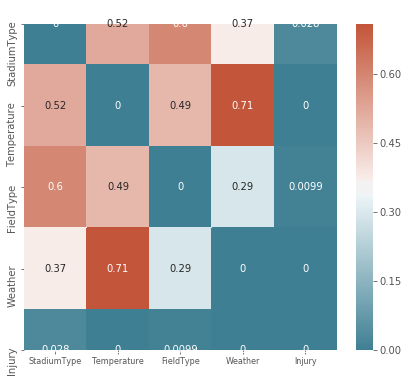

In [223]:
# Source:
# https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


# Source:
# https://stackoverflow.com/questions/51859894/how-to-plot-a-cramer-s-v-heatmap-for-categorical-features
def plot_cramers_v_heatmap(df, cols):
    corrM = np.zeros((len(cols),len(cols)))

    for col1, col2 in itertools.combinations(cols, 2):
        idx1, idx2 = cols.index(col1), cols.index(col2)
        corrM[idx1, idx2] = cramers_v(pd.crosstab(df[col1], df[col2]).values)
        corrM[idx2, idx1] = corrM[idx1, idx2]

    corr = pd.DataFrame(corrM, index=cols, columns=cols)
    fig, ax = plt.subplots(figsize=(7, 6))
    ax = sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax); 
    ax.set_title("Cramer V Correlation between Variables");


# columns = ['Weather', 'Temperature', 'StadiumType', 'FieldType', 'Weather', 'Injury']
# columns = ["StadiumType", "FieldType", "Weather", "Temperature", "Injury"]
columns = ['StadiumType', 'Temperature', 'FieldType', 'Weather', 'Injury']
plot_cramers_v_heatmap(game_inj_df, columns)

So, we can see that: <br>
<ul>
  <li>FieldType and StudiumType are highly correlated</li>
  <li>Tempreture and Weather are highlt correlated(obviously)</li>
    <li> <strong>Tempreture and StudiumType(and also a FieldType) are correlated!</strong></li>
</ul>
Although there are none correlations between Injury and everything else :с

Let's see Theil's U correlation.<br>
in human language, given the value of x, how many possible states does y have, and how often do they occur. Just like Cramer’s V, the output value is on the range of `[0,1]`, with the same interpretations as before — but unlike Cramer’s V, it is asymmetric, meaning U(x,y)≠U(y,x) (while V(x,y)=V(y,x), where V is Cramer’s V). Using Theil’s U in the simple case above will let us find out that knowing y means we know x, but not vice-versa.<br>
P.S.-symmetric value means that mean roughlt equals median.[More](https://www.siyavula.com/read/maths/grade-11/statistics/11-statistics-05)<br>
[MOOOAAAR of symmetric data](https://stats.stackexchange.com/questions/145159/how-to-tell-if-my-data-distribution-is-symmetric)<br>
[definition of quartiles](https://en.wikipedia.org/wiki/Quartile).Mean is (summ of all number)/(amount of number) and median is the middle of sorted array(or,if arrays isn't odd than the summ of 2 middle elemnts / 2).Basiaclly, to find a median we must sort the array.<br>

In other words, Theil's U method of finding correlations saves us from symmetry of the data type, which is used Cramer's V.More about symmetric and skewed data: [here](https://www.dummies.com/education/math/statistics/how-to-identify-skew-and-symmetry-in-a-statistical-histogram/) . It's more safe to use, otherwise we may see the loss of the information.

In [224]:
# https://github.com/shakedzy/dython/blob/master/dython/nominal.py

from collections import Counter
import math

def conditional_entropy(x, y, nan_strategy='replace', nan_replace_value=0):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    **Returns:** float
    Parameters
    ----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples with missing values, or 'replace'
        to replace all missing values with the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when nan_strategy is set to 'replace'.
    """
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

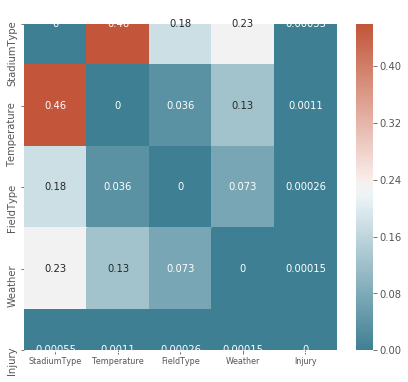

In [225]:
def plot_theils_u_heatmap(df, cols):
    corrM = np.zeros((len(cols),len(cols)))

    for col1, col2 in itertools.combinations(cols, 2):
        idx1, idx2 = cols.index(col1), cols.index(col2)
        corrM[idx1, idx2] = theils_u(df[col1].values, df[col2].values)
        corrM[idx2, idx1] = corrM[idx1, idx2]

    corr = pd.DataFrame(corrM, index=cols, columns=cols)
    fig, ax = plt.subplots(figsize=(7, 6))
    ax = sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax);
    ax.set_title("Theil's U Correlation between Variables");

columns = ['StadiumType', 'Temperature', 'FieldType', 'Weather', 'Injury']
plot_theils_u_heatmap(game_inj_df, columns)

Again, we can't say anything about the injuries

Let's explore the correlations between the injuries and the tempreture using box plot.<br>
More about how it works in this [article](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51)

In [253]:
# get the tempreture for non-injury and injury dataset
# & allows us to make multiply conditions.We must select outdoors StadiumType value, because only then tempretuer
# really matters.When aquired the needed info, get the tempreture columns
inj_temp = game_inj_df[(game_inj_df.StadiumType == 'Outdoor') & (game_inj_df.Injury == 1)].Temperature.values
non_inj_temp = game_inj_df[(game_inj_df.StadiumType == 'Outdoor') & (game_inj_df.Injury == 0)].Temperature.values


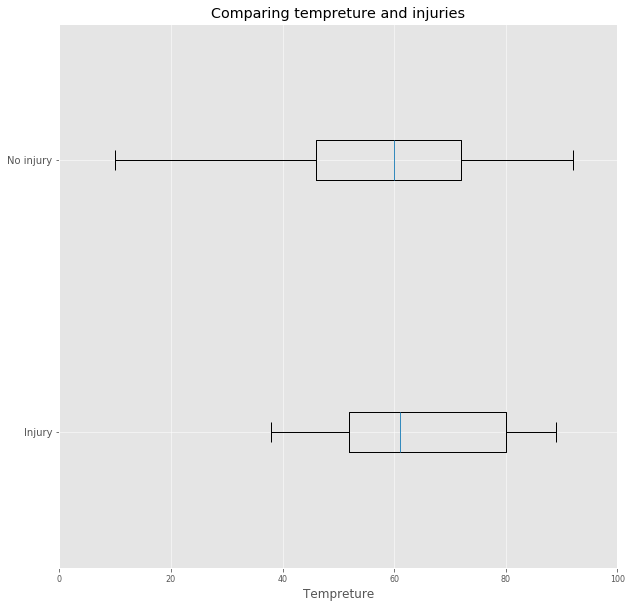

In [257]:
figure = plt.figure(figsize=(10,10))
# vet=False makes boxes horizontal
plt.boxplot([inj_temp, non_inj_temp], vert=False)
# Label sets the label for the whole axis, but ticks sets the labels to the respective values(this time 1 and 2 - injury
# and non-injury values)
plt.xlabel('Tempreture')
plt.title('Comparing tempreture and injuries', color='black')
plt.xlim(0, 100)
plt.yticks([1,2], ['Injury', 'No injury'])
plt.show()

Tempreture distribution.This plot shows the probability of occuring x degrees of Celcius.In another words, it shows the probability density for some for some value. KDE is an abbreviation of **Kernel Density Estimate**.It's more smooth than histogram(histogram is not the same as bar chart!First is used for continuos numerical data and the second for number of instances in categories(caregorical data that uses discrete numbers to count the instances).Here are [Data difference](http://scaryscientist.blogspot.com/2015/02/classification-of-data-types.html)(and more about [difference of continuos and discrete data](https://keydifferences.com/difference-between-discrete-and-continuous-data.html)) and  [Difference beetween graphs](https://keydifferences.com/difference-between-histogram-and-bar-graph.html)) because of using kernel smoothing, that allows us to ignore the noise and see the shape of the data: which point of value is most often often occured(because the histogram is dependent on bins for data distribution).<br>
[Reference](https://datavizcatalogue.com/methods/density_plot.html)

Text(0, 0.5, 'Disribution')

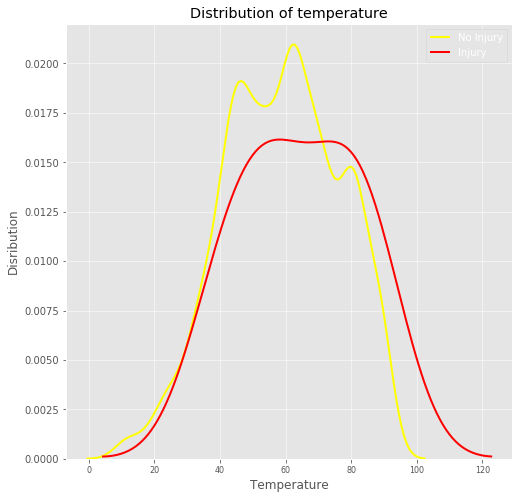

In [265]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.kdeplot(non_inj_temp, label='No Injury', color='yellow')
sns.kdeplot(inj_temp, label='Injury', color='red')
plt.title('Distribution of temperature', color='black')
plt.xlabel('Temperature')
plt.ylabel('Disribution')

Do temperature sets come from one data or is it entirely different(aka the data of temperature of injured was pulled from compeletely different country or different criteria and ect.).We use Kolmogorov-Smirnov test to check this out.It's null-hypothesis assumes that they are from the same distribution.If p-value is lower than 0.05 than we must reject the null-hypothesis => they are not from the same distribution.[more about p-value](https://www.youtube.com/watch?v=eyknGvncKLw)
and [about this test](https://stats.stackexchange.com/questions/83163/statistical-test-to-tell-whether-two-samples-are-pulled-from-the-same-population)

In [268]:
D, pvalue = ss.ks_2samp(non_inj_temp, inj_temp)
D, pvalue

(0.1803782838535909, 0.7292760464192929)

Pvalue is huge => the null-hypothethis is true => the assumption that they are from the same batch is true.

## Making assumption

Let's see if the type of field can influence the result(injury).

In [299]:
probability_of_inj = game_inj_df.loc[:, ['FieldType', 'Injury']].groupby('FieldType').mean()['Injury'] # shows the mean 
# of injury per TypeField
probability_of_inj

FieldType
Natural      0.003926
Synthetic    0.006661
Name: Injury, dtype: float64

Our null-hypothesis will be that the injuries on natural turf are less or equal to that on sythetic.

In [288]:
number_of_each_field = game_inj_df.loc[:, ['FieldType', 'Injury']].groupby('FieldType').size()
number_of_synt = number_of_each_field[1]
number_of_natural = number_of_each_field[0]
null_hyp =  game_inj_df.loc[:, ['FieldType', 'Injury']][game_inj_df.FieldType == 'Natural'].mean()[0]

Computing standard error(not the same as standard deviation!Deviation tells the how much data is spread out, but error tells us how much the mean of the means is spread out(i.e. standard deviation on all samples).[Good video](https://www.youtube.com/watch?v=A82brFpdr9g)<br>
z-score tells us how much(from -3 to 3) our sample(this time our probability of injury in opposite, synthetic, turf) standard errors above or below the mean(the error itself).More:[here](https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/z-score/)<br>
Finally, pvalue can be found the following way: what is the probability, that x falls in the range of z-score(how much the score deviates from the norm)?For pvalue we must find the opposite probability => 1 - probability of z-score.To find this probability we must compute the countinuos random value(the prob. that number falls in the interval of bell curve-density plot-computed by the hypothesis that area under curve equals to 1 and taking the difference between end and start point).Also, it's a normal distribution(reflection correspondingly to the mean: the graphs by 2 sides of the mean are the same).So, we must find nomral random continuos distribution(the hell long is that).More info in [this wonderful site](https://saylordotorg.github.io/text_introductory-statistics/s09-01-continuous-random-variables.html)<br>
Finally, we use CDF(cumulative distribution function) to sum up all the probabilities.[info](https://www.statisticshowto.datasciencecentral.com/cumulative-distribution-function/) 

In [304]:
# SE(standard error) = SD(standard deviation) / sqrt(amount of samples)
# for SD we must count probability for both injury on natural field and non-injury everywhere or injury on synthetic turf(
# opposite effect)
st_e = np.sqrt(null_hyp * (1 - null_hyp)/(number_of_synt + number_of_natural))

# z-score:
zs = (probability_of_inj[1] - probability_of_inj[0]) / st_e

print('z-score equals to {}'.format(zs))
print('So, pvalue is {}'.format(1 - ss.norm.cdf(zs)))

z-score equals to 3.3053797981973556
So, pvalue is 0.0004742388892970961


P-value is lesser than 0.05 => we reject the null-hypothesis, that tells us that injury on natural turf is less or equal than that on the synthetic => more injuries on the syntetic turf.

In [340]:
# Remove NA players, because otherwise we won't be able to join them

# Создай этот гребанный DF, что сюда закидывать

play_inj_df = injuries_dataframe_cleaned.dropna(subset=['PlayKey']).set_index('PlayKey').join(
    player_info.set_index('PlayKey'), how='outer', lsuffix = '_left', rsuffix='_right' )


# filling the NAN of injuries with zeros.Other doesn't matter to us: we will seek correlations between injuries and
# game moments.
play_inj_df['DM_M1'] = play_inj_df['DM_M1'].fillna(0).astype(int)
play_inj_df['DM_M7'] = play_inj_df['DM_M7'].fillna(0).astype(int)
play_inj_df['DM_M28'] = play_inj_df['DM_M28'].fillna(0).astype(int)
play_inj_df['DM_M42'] = play_inj_df['DM_M42'].fillna(0).astype(int)

play_inj_df.DM_M1 = play_inj_df.DM_M1 - play_inj_df.DM_M7
play_inj_df.DM_M7 = play_inj_df.DM_M7 - play_inj_df.DM_M28
play_inj_df.DM_M28 = play_inj_df.DM_M28 - play_inj_df.DM_M42


# Injury to seek correlation beetween them.If there is an injury, than place 1, otherwise 0(although 
# when joining DF the default way we will have no non-1 values).
play_inj_df['Injury'] = play_inj_df.loc[:, 'DM_M1'] + play_inj_df.loc[:, 'DM_M7'] + (play_inj_df.loc[:, 'DM_M28'] 
+ play_inj_df.loc[:, 'DM_M42'])



# # drop unneeded PlayerKey, PlayKey
play_inj_df = play_inj_df.drop(columns=['Surface'])

play_inj_df.head()


# # We should create dummies for all categorical values.We can use the fucntion on the whole DF.
# # Thanks to dropping first there will be no multicorrelation
# # Drop FieldType_nan dummies,because they are none.
# play_inj_dummies = pd.get_dummies(play_inj_df, columns = ['PlayType', 'PositionGroup'], dummy_na = True, drop_first = True)



# # look for the correlations using .corr()
# correlated_play = play_inj_dummies.loc[:, ['PlayType_Pass', 'PlayType_Kickoff', 'PlayType_Punt', 'PlayType_Rush',
#                                   'PositionGroup_QB', 'PositionGroup_DL', 'PositionGroup_LB', 'PositionGroup_OL',
#                                   'PositionGroup_RB', 'PositionGroup_SPEC', 'PositionGroup_TE', 'PositionGroup_WR',
#                                   'Injury']].corr()

# fig = plt.figure(figsize=(10,10))
# # choose_diverging_palette works only in IPython notebooks: interactive choice of colors.Otherwise we can just indicate
# # which color we need
# sns.heatmap(correlated_play, annot=True)
# plt.title('Correlations', color='black')

,PlayerKey_left,GameID,BodyPart,DM_M1,DM_M7,DM_M28,DM_M42,PlayerKey_right,RosterPosition,Position,PositionGroup,PlayerGamePlay,Injury
PlayKey,,,,,,,,,,,,,
26624-1-1,NaN,NaN,NaN,0,0,0,0,26624,Quarterback,QB,QB,1,0
26624-1-10,NaN,NaN,NaN,0,0,0,0,26624,Quarterback,QB,QB,10,0
26624-1-11,NaN,NaN,NaN,0,0,0,0,26624,Quarterback,QB,QB,11,0
26624-1-12,NaN,NaN,NaN,0,0,0,0,26624,Quarterback,QB,QB,12,0
26624-1-13,NaN,NaN,NaN,0,0,0,0,26624,Quarterback,QB,QB,13,0
